### WGAN with Deep Convolution

In [1]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
from forgebox.ftorch import FG

In [3]:
fg = FG("wgan_dc",remark="wgan and with deep convolutional model")
p = fg.p

==========hyper params==========
{'hs': 2048}


### Data Pipeline

In [4]:
train = MNIST("/data/MNIST_TORCH/", train = True, transform=transforms.Compose([transforms.ToTensor()]), download=False)
valid = MNIST("/data/MNIST_TORCH/", train = False, transform=transforms.Compose([transforms.ToTensor()]), download=False)

In [5]:
from torch import nn
import torch
from torch.utils.data import DataLoader

In [6]:
# next(iter(DataLoader(train)))

In [7]:
CUDA = torch.cuda.is_available()

In [8]:
def conv_layer(in_,out,ks=3,padding=None,bn=False, act=True):
    convs = [
        nn.Conv2d(in_,out, 
                kernel_size=3, 
                padding=ks//2 if padding== None else padding, 
                bias=False if bn else True,),
            ]
    if bn: convs.append(nn.BatchNorm2d(out,))
    if act: convs.append(nn.ReLU())
    return nn.Sequential(*convs)

class res_block(nn.Module):
    def __init__(self, in_,ks=3, hs=None, bn = False):
        super().__init__()
        in_ = in_
        hs = hs if hs else in_
        self.convs = nn.Sequential(*[
            conv_layer(in_, hs, bn = True, ),
            conv_layer(hs, in_, bn = True, ),
        ])
    
    def forward(self,x):
        return x + self.convs(x)
        
class G(nn.Module):
    def __init__(self, in_,):
        super().__init__()
        self.in_ = in_
        self.start = nn.Linear(in_,28*28)
        self.conv_blocks = nn.Sequential(*[
            conv_layer(1,32),
            res_block(32),conv_layer(32,64),
            res_block(64),conv_layer(64,32),
            conv_layer(32,1, act= False, bn = False),
        ])        
    def forward(self,x, ):
        bs = x.size()[0]
        x = self.start(x)
        x = torch.reshape(x,(bs,1,28,28))
        x = self.conv_blocks(x)
        return torch.sigmoid(x)
    
    def new_images(self, number):
        x = torch.rand(number,self.in_)
        if CUDA: x=x.cuda()
        x = self.forward(x)
        return x
    
class D(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.conv_blocks = nn.Sequential(*[
            conv_layer(1,32),res_block(32),nn.AvgPool2d((2,2)),
            conv_layer(32,64),res_block(64),nn.AvgPool2d((2,2)),
            conv_layer(64,32,act=False, bn=False),
#             nn.AdaptiveAvgPool2d((1,1))
        ])
        self.fcb=nn.Sequential(*[
            nn.Linear(49*32,512,bias=False),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,1,bias=False)
        ])
        
    def forward(self,x):
        x = self.conv_blocks(x)
        bs = x.size()[0]
        x = torch.reshape(x,(bs,49*32))
        x = self.fcb(x)
        return x

In [9]:
d = D()

In [10]:
a = torch.rand(32,1,28,28)

In [11]:
d(a).size()

torch.Size([32, 1])

In [12]:
from forgebox.ftorch.train import Trainer
from forgebox.ftorch.callbacks import stat

from torch.optim import Adam, RMSprop

In [13]:
trainer = Trainer(dataset=train, batch_size=32, print_on=5,fg=fg, callbacks=[stat])

In [14]:
g,d = G(100,),D()
if CUDA:
    g,d = g.cuda(),d.cuda()
opt_G = RMSprop(g.parameters(),lr= 5e-5)
opt_D = RMSprop(d.parameters(),lr= 5e-5)

trainer.train_G = True
trainer.loss_G = 0
trainer.loss_D = 0
@trainer.step_train
def action(*args, **kwargs):
    if kwargs["ite"] %6 ==5:
        trainer.train_G = True
    else:
        trainer.train_G = False
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    real,y = args[0]
    
    bs = real.size()[0]
    z = torch.rand(bs, 100)
    
    if CUDA:
        real = real.cuda()
        z = z.cuda()
    fake = g(z)
    x = torch.cat([real,fake], dim=0)
    if trainer.train_G:
        
        loss = - d(fake).mean()
        trainer.loss_G = loss.item()
        loss.backward()
        opt_G.step()
    else:
        loss = -(d(real).mean() - d(fake).mean())
        trainer.loss_D = loss.item()
        loss.backward()
        opt_D.step()
        for p in d.parameters():
            p.data.clamp_(-1e-2, 1e-2)
    return {"loss":loss.item(),"g":trainer.loss_G, "d":trainer.loss_D}

In [15]:
trainer.train(50)

,d,epoch,g,iter,loss,timestamp
mean,-0.005771,0.0,0.003001,937.0,-0.004304,0.024166
min,-0.010867,0.0,0.000000,0.0,-0.010867,0.000000
max,0.000002,0.0,0.005644,1874.0,0.005644,45.310846


,d,epoch,g,iter,loss,timestamp
mean,-0.007659,1.0,0.003859,937.0,-0.005734,0.024102
min,-0.009876,1.0,0.001484,0.0,-0.009876,0.000000
max,-0.004567,1.0,0.005808,1874.0,0.005808,45.191981


,d,epoch,g,iter,loss,timestamp
mean,-0.008074,2.0,0.004007,937.0,-0.006068,0.024137
min,-0.010402,2.0,0.001286,0.0,-0.010402,0.000000
max,-0.005376,2.0,0.006361,1874.0,0.006361,45.256603


,d,epoch,g,iter,loss,timestamp
mean,-0.008998,3.0,0.004622,937.0,-0.006731,0.024147
min,-0.011819,3.0,0.001675,0.0,-0.011819,0.000000
max,-0.005997,3.0,0.006495,1874.0,0.006495,45.276472


,d,epoch,g,iter,loss,timestamp
mean,-0.009791,4.0,0.004794,937.0,-0.007356,0.024091
min,-0.012948,4.0,0.002057,0.0,-0.012948,0.000000
max,-0.006623,4.0,0.007341,1874.0,0.007341,45.170819


,d,epoch,g,iter,loss,timestamp
mean,-0.010042,5.0,0.004845,937.0,-0.007557,0.024149
min,-0.012988,5.0,0.000888,0.0,-0.012988,0.000000
max,-0.006350,5.0,0.007219,1874.0,0.007219,45.279513


,d,epoch,g,iter,loss,timestamp
mean,-0.010355,6.0,0.005030,937.0,-0.007795,0.024108
min,-0.013263,6.0,0.002272,0.0,-0.013263,0.000000
max,-0.006154,6.0,0.007187,1874.0,0.007187,45.202850


,d,epoch,g,iter,loss,timestamp
mean,-0.010646,7.0,0.005450,937.0,-0.007965,0.024130
min,-0.013937,7.0,0.002292,0.0,-0.013937,0.000000
max,-0.004845,7.0,0.007263,1874.0,0.007263,45.243568


,d,epoch,g,iter,loss,timestamp
mean,-0.010999,8.0,0.005484,937.0,-0.008237,0.024167
min,-0.014026,8.0,0.002381,0.0,-0.014026,0.000000
max,-0.004181,8.0,0.007240,1874.0,0.007240,45.313961


,d,epoch,g,iter,loss,timestamp
mean,-0.011041,9.0,0.005569,937.0,-0.008268,0.024197
min,-0.014525,9.0,0.002469,0.0,-0.014525,0.000000
max,-0.004636,9.0,0.007424,1874.0,0.007424,45.369216


,d,epoch,g,iter,loss,timestamp
mean,-0.010701,10.0,0.005564,937.0,-0.007989,0.024196
min,-0.014652,10.0,0.002096,0.0,-0.014652,0.000000
max,-0.005410,10.0,0.007402,1874.0,0.007402,45.366699


,d,epoch,g,iter,loss,timestamp
mean,-0.010356,11.0,0.005240,937.0,-0.007754,0.024193
min,-0.014174,11.0,-0.000394,0.0,-0.014174,0.000000
max,-0.004528,11.0,0.007557,1874.0,0.007557,45.361296


,d,epoch,g,iter,loss,timestamp
mean,-0.010279,12.0,0.005233,937.0,-0.007678,0.024197
min,-0.014128,12.0,0.000060,0.0,-0.014128,0.000000
max,-0.004416,12.0,0.007992,1874.0,0.007992,45.369419


,d,epoch,g,iter,loss,timestamp
mean,-0.010214,13.0,0.005112,937.0,-0.007652,0.024159
min,-0.014036,13.0,0.001512,0.0,-0.014036,0.000000
max,-0.004096,13.0,0.007617,1874.0,0.007617,45.298266


,d,epoch,g,iter,loss,timestamp
mean,-0.009860,14.0,0.004920,937.0,-0.007396,0.024146
min,-0.013613,14.0,-0.000903,0.0,-0.013613,0.000000
max,-0.001141,14.0,0.007609,1874.0,0.007609,45.273651


,d,epoch,g,iter,loss,timestamp
mean,-0.009890,15.0,0.004926,937.0,-0.007411,0.024145
min,-0.013418,15.0,0.000834,0.0,-0.013418,0.000000
max,-0.002698,15.0,0.007255,1874.0,0.007255,45.271980


,d,epoch,g,iter,loss,timestamp
mean,-0.009826,16.0,0.005032,937.0,-0.007333,0.024226
min,-0.013385,16.0,-0.000780,0.0,-0.013385,0.000000
max,-0.004016,16.0,0.007384,1874.0,0.007384,45.424098


,d,epoch,g,iter,loss,timestamp
mean,-0.009747,17.0,0.004780,937.0,-0.007309,0.024191
min,-0.013329,17.0,0.000654,0.0,-0.013329,0.000000
max,-0.003700,17.0,0.006975,1874.0,0.006975,45.358109


,d,epoch,g,iter,loss,timestamp
mean,-0.009651,18.0,0.004840,937.0,-0.007225,0.024132
min,-0.013394,18.0,0.000528,0.0,-0.013394,0.000000
max,-0.003619,18.0,0.007068,1874.0,0.007068,45.247599


,d,epoch,g,iter,loss,timestamp
mean,-0.009639,19.0,0.004747,937.0,-0.007237,0.024177
min,-0.013289,19.0,-0.000432,0.0,-0.013289,0.000000
max,-0.004035,19.0,0.007270,1874.0,0.007270,45.331395


,d,epoch,g,iter,loss,timestamp
mean,-0.009626,20.0,0.004826,937.0,-0.007193,0.024205
min,-0.013573,20.0,-0.001170,0.0,-0.013573,0.000000
max,-0.003521,20.0,0.007315,1874.0,0.007315,45.385310


,d,epoch,g,iter,loss,timestamp
mean,-0.009657,21.0,0.004890,937.0,-0.007238,0.024120
min,-0.013776,21.0,-0.002654,0.0,-0.013776,0.000000
max,-0.002799,21.0,0.007512,1874.0,0.007512,45.225822


,d,epoch,g,iter,loss,timestamp
mean,-0.009679,22.0,0.004939,937.0,-0.007231,0.024150
min,-0.013166,22.0,-0.000124,0.0,-0.013166,0.000000
max,-0.003028,22.0,0.007249,1874.0,0.007249,45.281748


,d,epoch,g,iter,loss,timestamp
mean,-0.009637,23.0,0.004827,937.0,-0.007210,0.024146
min,-0.013706,23.0,-0.000913,0.0,-0.013706,0.000000
max,-0.003848,23.0,0.007214,1874.0,0.007214,45.274530


,d,epoch,g,iter,loss,timestamp
mean,-0.009850,24.0,0.004846,937.0,-0.007398,0.024146
min,-0.016243,24.0,-0.000534,0.0,-0.016243,0.000000
max,-0.003528,24.0,0.008272,1874.0,0.008272,45.273014


,d,epoch,g,iter,loss,timestamp
mean,-0.009557,25.0,0.005570,937.0,-0.007020,0.024225
min,-0.013723,25.0,-0.002997,0.0,-0.013723,0.000000
max,0.000778,25.0,0.008993,1874.0,0.008993,45.421048


,d,epoch,g,iter,loss,timestamp
mean,-0.009186,26.0,0.004562,937.0,-0.006886,0.024172
min,-0.013464,26.0,-0.001284,0.0,-0.013464,0.000000
max,-0.002380,26.0,0.007045,1874.0,0.007045,45.322446


,d,epoch,g,iter,loss,timestamp
mean,-0.009377,27.0,0.004752,937.0,-0.007023,0.024178
min,-0.012930,27.0,-0.000597,0.0,-0.012930,0.000000
max,-0.003872,27.0,0.007525,1874.0,0.007525,45.333891


,d,epoch,g,iter,loss,timestamp
mean,-0.011114,28.0,0.007199,937.0,-0.008064,0.024130
min,-0.014896,28.0,0.001462,0.0,-0.014896,0.000000
max,-0.005993,28.0,0.009310,1874.0,0.009310,45.244679


,d,epoch,g,iter,loss,timestamp
mean,-0.010040,29.0,0.008715,937.0,-0.006910,0.024169
min,-0.012217,29.0,0.001067,0.0,-0.012217,0.000000
max,-0.000158,29.0,0.009965,1874.0,0.009965,45.317720


,d,epoch,g,iter,loss,timestamp
mean,-0.005249,30.0,0.003111,937.0,-0.003847,0.024224
min,-0.009182,30.0,-0.001741,0.0,-0.009182,0.000000
max,-0.001205,30.0,0.005525,1874.0,0.005525,45.420764


,d,epoch,g,iter,loss,timestamp
mean,-0.007208,31.0,0.003058,937.0,-0.005487,0.024192
min,-0.010357,31.0,-0.000946,0.0,-0.010357,0.000000
max,-0.003029,31.0,0.006537,1874.0,0.006537,45.359696


,d,epoch,g,iter,loss,timestamp
mean,-0.008045,32.0,0.003874,937.0,-0.006070,0.024225
min,-0.011915,32.0,-0.001682,0.0,-0.011915,0.000000
max,-0.000696,32.0,0.006643,1874.0,0.006643,45.421591


,d,epoch,g,iter,loss,timestamp
mean,-0.008598,33.0,0.004264,937.0,-0.006439,0.024215
min,-0.012644,33.0,-0.001059,0.0,-0.012644,0.000000
max,-0.002482,33.0,0.007557,1874.0,0.007557,45.402505


,d,epoch,g,iter,loss,timestamp
mean,-0.008931,34.0,0.004648,937.0,-0.006682,0.024176
min,-0.013248,34.0,-0.002777,0.0,-0.013248,0.000000
max,-0.001781,34.0,0.007406,1874.0,0.007406,45.329419


,d,epoch,g,iter,loss,timestamp
mean,-0.009160,35.0,0.004655,937.0,-0.006844,0.024204
min,-0.013894,35.0,0.000167,0.0,-0.013894,0.000000
max,-0.001564,35.0,0.007608,1874.0,0.007608,45.382704


,d,epoch,g,iter,loss,timestamp
mean,-0.009356,36.0,0.004954,937.0,-0.006965,0.024143
min,-0.013636,36.0,0.000394,0.0,-0.013636,0.000000
max,-0.003357,36.0,0.007732,1874.0,0.007732,45.267203


,d,epoch,g,iter,loss,timestamp
mean,-0.009306,37.0,0.004870,937.0,-0.006964,0.024208
min,-0.013056,37.0,0.000488,0.0,-0.013056,0.000000
max,-0.002106,37.0,0.007844,1874.0,0.007844,45.389742


,d,epoch,g,iter,loss,timestamp
mean,-0.009423,38.0,0.004981,937.0,-0.007005,0.024158
min,-0.013375,38.0,-0.000273,0.0,-0.013375,0.000000
max,-0.002324,38.0,0.007931,1874.0,0.007931,45.295903


,d,epoch,g,iter,loss,timestamp
mean,-0.010171,39.0,0.006991,937.0,-0.007288,0.024129
min,-0.014651,39.0,-0.001848,0.0,-0.014651,0.000000
max,-0.000256,39.0,0.010479,1874.0,0.010479,45.241602


,d,epoch,g,iter,loss,timestamp
mean,-0.008851,40.0,0.004476,937.0,-0.006614,0.024187
min,-0.012881,40.0,-0.000712,0.0,-0.012881,0.000000
max,-0.001245,40.0,0.007533,1874.0,0.007533,45.351522


,d,epoch,g,iter,loss,timestamp
mean,-0.009296,41.0,0.004757,937.0,-0.006955,0.024185
min,-0.013802,41.0,-0.001808,0.0,-0.013802,0.000000
max,-0.002984,41.0,0.007733,1874.0,0.007733,45.346832


,d,epoch,g,iter,loss,timestamp
mean,-0.009297,42.0,0.004929,937.0,-0.006921,0.024191
min,-0.013562,42.0,-0.000689,0.0,-0.013562,0.000000
max,-0.002058,42.0,0.008071,1874.0,0.008071,45.358540


,d,epoch,g,iter,loss,timestamp
mean,-0.009411,43.0,0.004751,937.0,-0.007039,0.024169
min,-0.014282,43.0,-0.000433,0.0,-0.014282,0.000000
max,-0.003894,43.0,0.007681,1874.0,0.007681,45.316964


,d,epoch,g,iter,loss,timestamp
mean,-0.009423,44.0,0.005024,937.0,-0.007015,0.024155
min,-0.014041,44.0,0.000393,0.0,-0.014041,0.000000
max,-0.001433,44.0,0.007706,1874.0,0.007706,45.291364


,d,epoch,g,iter,loss,timestamp
mean,-0.009346,45.0,0.004984,937.0,-0.006944,0.024182
min,-0.013259,45.0,-0.001854,0.0,-0.013259,0.000000
max,-0.002961,45.0,0.007892,1874.0,0.007892,45.342010


,d,epoch,g,iter,loss,timestamp
mean,-0.009539,46.0,0.005043,937.0,-0.007106,0.024151
min,-0.014174,46.0,-0.000333,0.0,-0.014174,0.000000
max,-0.002824,46.0,0.007678,1874.0,0.007678,45.282208


,d,epoch,g,iter,loss,timestamp
mean,-0.009436,47.0,0.004944,937.0,-0.007018,0.024214
min,-0.015203,47.0,-0.000467,0.0,-0.015203,0.000000
max,-0.002740,47.0,0.008020,1874.0,0.008020,45.401934


,d,epoch,g,iter,loss,timestamp
mean,-0.009305,48.0,0.004918,937.0,-0.006918,0.024170
min,-0.014024,48.0,-0.000011,0.0,-0.014024,0.000000
max,-0.003204,48.0,0.007726,1874.0,0.007726,45.318832


,d,epoch,g,iter,loss,timestamp
mean,-0.009293,49.0,0.004911,937.0,-0.006926,0.024211
min,-0.013576,49.0,-0.001671,0.0,-0.013576,0.000000
max,-0.002881,49.0,0.007823,1874.0,0.007823,45.395221


In [16]:
from matplotlib import pyplot as plt
%matplotlib inline

In [17]:
images = g.new_images(10)
if CUDA: images = images.cpu()

In [18]:
from IPython.display import display_jpeg

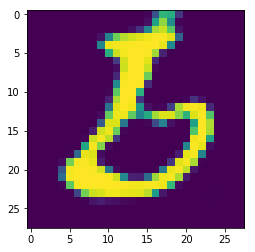

In [19]:
plt.imshow(images.data.numpy()[0][0])

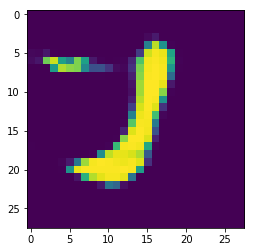

In [20]:
plt.imshow(images.data.numpy()[1][0])

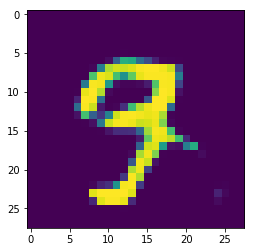

In [21]:
plt.imshow(images.data.numpy()[2][0])

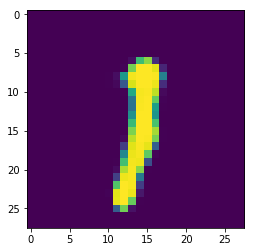

In [22]:
plt.imshow(images.data.numpy()[3][0])

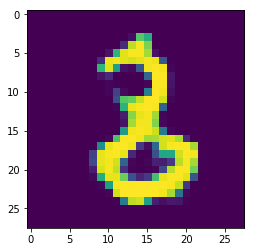

In [23]:
plt.imshow(images.data.numpy()[4][0])

### Findings

* No batchnorm!